# Main Modelling KNN and Decision Tree - Gridsearch 

* read in dataframe pickle
* final selected features based on initial analysis with logistic regression
* run KNN and Decision Tree with initial analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import label_binarize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import class to run modelling steps
from translator_modelling import Modelling

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load the dataframe containing text chunks and related variables

In [2]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [3]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,then_adv,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,vlong_words_count
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(5212, 142)

### Check the baseline accuracy

In [5]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.39927091327705294

## KNN classification with cross validation

In [6]:
# prepare modelling
model = KNeighborsClassifier()
knn = Modelling(df, model)

# select feature groups for modelling
predictor_cols = knn.feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = knn.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = knn.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
params = {
            'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']}

# lreg_gs_01 = lr.gridsearch(model, params, X_train, y_train)
knn.gridsearch(params, X_train, y_train)

# score the fitted model
knn_gs_01_results = knn.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'knn_gs_01'
out_full_path = out_path + out_name + '.pkl'
knn.save_model(out_full_path)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   58.8s
[Parallel(n_jobs=2)]: Done 140 out of 140 | elapsed:  2.8min finished


Best Parameters:
{'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'distance'}
Best estimator mean cross validated training score:
0.5646428355514869
Best estimator score on the full training set:
1.0
Best estimator score on the test set:
0.5906040268456376
ROC-AUC score on the test set:
Class 0: 0.78
Class 1: 0.81
Class 2: 0.83


#### KNN does not do as well as logistic regression for the moment
* best parameters have k=50, later we could perhaps try to test more around this value to see if a slight improvement is possible

## Confusion Matrix

In [7]:
print(pd.DataFrame(knn_gs_01_results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 210              121                 14
actual rubin                     74              334                  8
actual gabriel                   94              116                 72


## Classification Report

In [9]:
predictions = knn.model_gs.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.61      0.58       345
           1       0.58      0.80      0.68       416
           2       0.77      0.26      0.38       282

    accuracy                           0.59      1043
   macro avg       0.64      0.56      0.55      1043
weighted avg       0.62      0.59      0.57      1043



As KNN is a non-parametric model we don't have any feature importance to analysis and draw understanding from. This is a drawback for this particular project where we are interested in undertstanding what differentiates the translators

## Decision Tree classification with cross validation

In [10]:
# prepare modelling
model = DecisionTreeClassifier()
dtr = Modelling(df, model)

# select feature groups for modelling
predictor_cols = dtr.feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = dtr.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = dtr.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
params = {
    'max_depth': list(range(1, 15))+[None],
    'max_features': [None, 1, 3, 5, 7],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01],
    'criterion': ['gini', 'entropy']
}

# lreg_gs_01 = lr.gridsearch(model, params, X_train, y_train)
dtr.gridsearch(params, X_train, y_train)

# score the fitted model
dt_gs_01_results = dtr.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'dt_gs_01'
out_full_path = out_path + out_name + '.pkl'
dtr.save_model(out_full_path)

Fitting 5 folds for each of 6600 candidates, totalling 33000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 270 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 2670 tasks      | elapsed:   32.5s
[Parallel(n_jobs=2)]: Done 6670 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 11726 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 17410 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done 26046 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done 33000 out of 33000 | elapsed:  6.9min finished


Best Parameters:
{'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_split': 50}
Best estimator mean cross validated training score:
0.5389776054306614
Best estimator score on the full training set:
0.592468217798033
Best estimator score on the test set:
0.5148609779482263
ROC-AUC score on the test set:
Class 0: 0.66
Class 1: 0.73
Class 2: 0.75


#### Looking at the Cross Validation mean score, Decision Tree does not do as well as logistic regression or KNN for the moment

### Confusion Matrix

In [11]:
print(pd.DataFrame(dt_gs_01_results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 176              116                 53
actual rubin                    108              260                 48
actual gabriel                   99               82                101


### Classification Report

In [13]:
predictions = dtr.model_gs.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.46      0.51      0.48       345
           1       0.57      0.62      0.59       416
           2       0.50      0.36      0.42       282

    accuracy                           0.51      1043
   macro avg       0.51      0.50      0.50      1043
weighted avg       0.51      0.51      0.51      1043



### Feature importances

Decision trees can give us feature importances. The higher the number the more important the predictor was for deciding splits at nodes.
Technically, "the importance of a feature is computed as the (normalized) total reduction of the
criterion brought by that feature." 

That means a feature is more important 

- if it is used in many different nodes, 
- if the difference in the measures of Gini or entropy are before and after the split is high

Feature importances are normalized in the sense of summing up to one.

In [14]:
# feature importances
feature_importances = dtr.model_gs.best_estimator_.feature_importances_
df_feat_imp = pd.DataFrame(list(zip(X_test.columns, dtr.model_gs.best_estimator_.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)

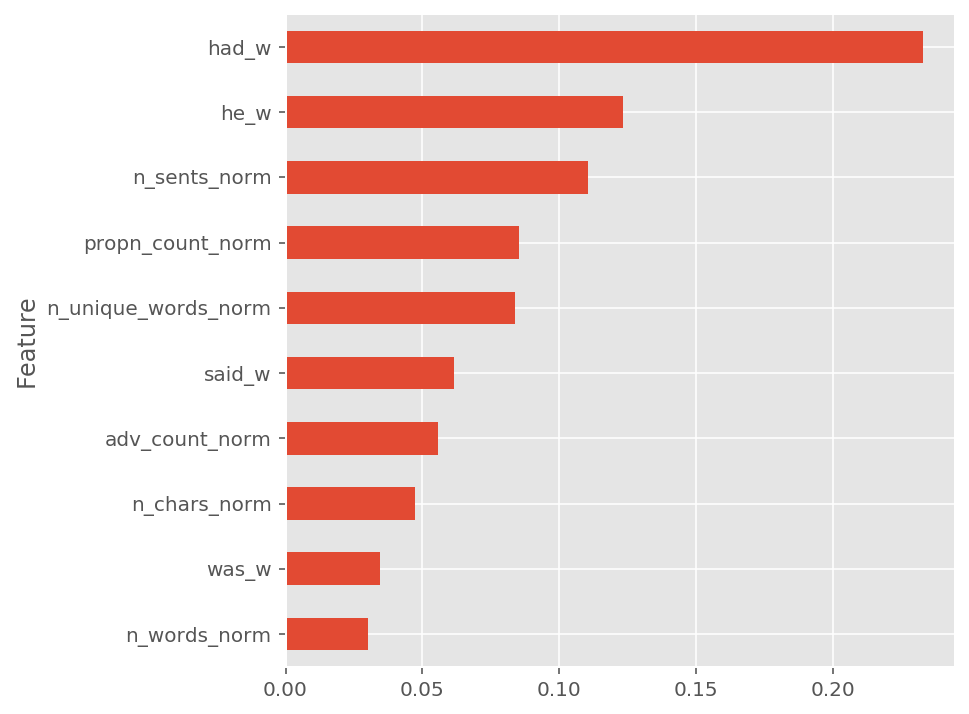

In [17]:
df_feat_imp.set_index('Feature')['Importance'].sort_values(ascending=True).tail(10) \
                .plot(kind='barh', figsize=(6,6))
plt.show()

'had' and 'he' as most important features raises questions - more related to the tense and point of view (first person, third person etc.?). This is investigated in a later notebook